In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time, TimeDelta
from astropy.constants import c
import astropy.units as u

# Antenna positions in east-west direction (meters)
antennas = {
    0: (0, 0, 0),
    1: (14, 0, 0),
    2: (28, 0, 0)
}

# Baselines in meters
baselines = {
    (0, 1): np.array([14, 0, 0]),
    (0, 2): np.array([28, 0, 0]),
    (1, 2): np.array([14, 0, 0])
}

# Source coordinates and fluxes at the time of observation (at 50 MHz freq)
sources = [
    {'coords': SkyCoord(ra=0*u.deg, dec=-30.72152777777791*u.deg), 'flux': 2},
    {'coords': SkyCoord(ra=120*u.deg, dec=-30.72152777777791*u.deg), 'flux': 4},
    {'coords': SkyCoord(ra=240*u.deg, dec=-30.72152777777791*u.deg), 'flux': 6}
]

sp_index = 0  # Spectral index for all sources

# Location and observation time
hera_lon = 21.428305555555557
hera_lat = -30.72152777777791
hera_height = 1073.0
location = EarthLocation.from_geodetic(lat=hera_lat, lon=hera_lon, height=hera_height)
obstime_start = Time("2024-06-05T00:00:00", format="isot", scale="utc")

# Observation frequency and wavelength
freqs = np.linspace(1e8, 2e8, 100)  # Frequencies from 100 MHz to 200 MHz
wavelengths = c / freqs

# Half-power beam width (assuming 10 degrees)
theta_HPBW = np.deg2rad(10.9)

# Calculate complex visibility
def calculate_visibility(antennas, baselines, sources, location, obstime, wavelengths, freqs, sp_index):
    visibilities = {key: np.zeros(len(wavelengths), dtype=complex) for key in baselines.keys()}
    
    for i, (wavelength, freq) in enumerate(zip(wavelengths, freqs)):
        for (ant1, ant2), baseline in baselines.items():
            u, v, w = np.array(baseline) / wavelength.value  # Convert baseline to units of wavelength
            
            visibility = 0j
            for source in sources:
                altaz = source['coords'].transform_to(AltAz(obstime=obstime, location=location))
                az, alt = altaz.az.rad, altaz.alt.rad
                
                theta = np.deg2rad(90 - altaz.alt.deg)
                l = np.cos(alt) * np.cos(az)
                m = np.cos(alt) * np.sin(az)
                n = np.sin(alt)
                
                # Projected baseline component in the direction of the source
                b_dot_s = u * l + v * m + w * n
                
                # Gaussian primary beam pattern
                A_theta = (np.exp(- (theta / (np.sqrt(2) * theta_HPBW))**2))**2
                
                # Flux adjusted by spectral index
                flux_adj = source['flux'] * (freq / 50e6)**sp_index
                
                # Add contribution to visibility with beam pattern and flux adjustment
                visibility += flux_adj * A_theta * np.exp(-2j * np.pi * b_dot_s)
            
            visibilities[(ant1, ant2)][i] = visibility
    
    return visibilities

# Calculate modulus and phase angle
def calculate_modulus_phase(visibilities):
    moduli = {key: np.abs(val) for key, val in visibilities.items()}
    phases = {key: np.angle(val) for key, val in visibilities.items()}
    return moduli, phases

# Calculate visibility array for every 4 seconds over 24 hours
seconds_per_hour = 3600
total_seconds = 24 * seconds_per_hour
time_interval = 4  # Run every 4 seconds
moduli_over_time = {key: [] for key in baselines.keys()}
phases_over_time = {key: [] for key in baselines.keys()}
for second in range(0, total_seconds, time_interval):
    obstime = obstime_start + TimeDelta(second, format='sec')
    visibility_dict = calculate_visibility(antennas, baselines, sources, location, obstime, wavelengths, freqs, sp_index)
    moduli, phases = calculate_modulus_phase(visibility_dict)
    
    for key in baselines.keys():
        moduli_over_time[key].append(moduli[key])
        phases_over_time[key].append(phases[key])

# Convert lists to numpy arrays for plotting
for key in baselines.keys():
    moduli_over_time[key] = np.array(moduli_over_time[key])
    phases_over_time[key] = np.array(phases_over_time[key])

# Plot modulus vs time for each baseline
time_points = np.arange(0, total_seconds, time_interval)
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

baseline_keys = list(baselines.keys())

for i, key in enumerate(baseline_keys):
    ax[i, 0].plot(time_points, moduli_over_time[key][:, 0], marker='o', label=f"Baseline {key}")
    ax[i, 0].set_xlabel('Time (seconds)')
    ax[i, 0].set_ylabel('Modulus of Visibility')
    ax[i, 0].set_title(f'Modulus of Visibility vs Time for Baseline {key}')
    ax[i, 0].legend()
    ax[i, 0].grid(True)
    
    ax[i, 1].plot(time_points, phases_over_time[key][:, 0], marker='o', label=f"Baseline {key}")
    ax[i, 1].set_xlabel('Time (seconds)')
    ax[i, 1].set_ylabel('Phase of Visibility (radians)')
    ax[i, 1].set_title(f'Phase of Visibility vs Time for Baseline {key}')
    ax[i, 1].legend()
    ax[i, 1].grid(True)

plt.tight_layout()
plt.show()

# Plot heatmaps
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

for i, key in enumerate(baseline_keys):
    im0 = ax[i, 0].imshow(moduli_over_time[key], aspect='auto', origin='lower', extent=[0, total_seconds, freqs[0] / 1e6, freqs[-1] / 1e6])
    ax[i, 0].set_xlabel('Time (seconds)')
    ax[i, 0].set_ylabel('Frequency (MHz)')
    ax[i, 0].set_title(f'Modulus of Visibility for Baseline {key}')
    fig.colorbar(im0, ax=ax[i, 0])
    
    im1 = ax[i, 1].imshow(phases_over_time[key], aspect='auto', origin='lower', extent=[0, total_seconds, freqs[0] / 1e6, freqs[-1] / 1e6])
    ax[i, 1].set_xlabel('Time (seconds)')
    ax[i, 1].set_ylabel('Frequency (MHz)')
    ax[i, 1].set_title(f'Phase of Visibility for Baseline {key}')
    fig.colorbar(im1, ax=ax[i, 1])

plt.tight_layout()
plt.show()

# Plot modulus vs frequency at a particular time (e.g., 0 seconds)
time_index = 0
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

for i, key in enumerate(baseline_keys):
    ax[i].plot(freqs / 1e6, moduli_over_time[key][time_index, :], marker='o', label=f"Baseline {key}")
    ax[i].set_xlabel('Frequency (MHz)')
    ax[i].set_ylabel('Modulus of Visibility')
    ax[i].set_title(f'Modulus of Visibility vs Frequency for Baseline {key} at Time {time_points[time_index]} seconds')
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()


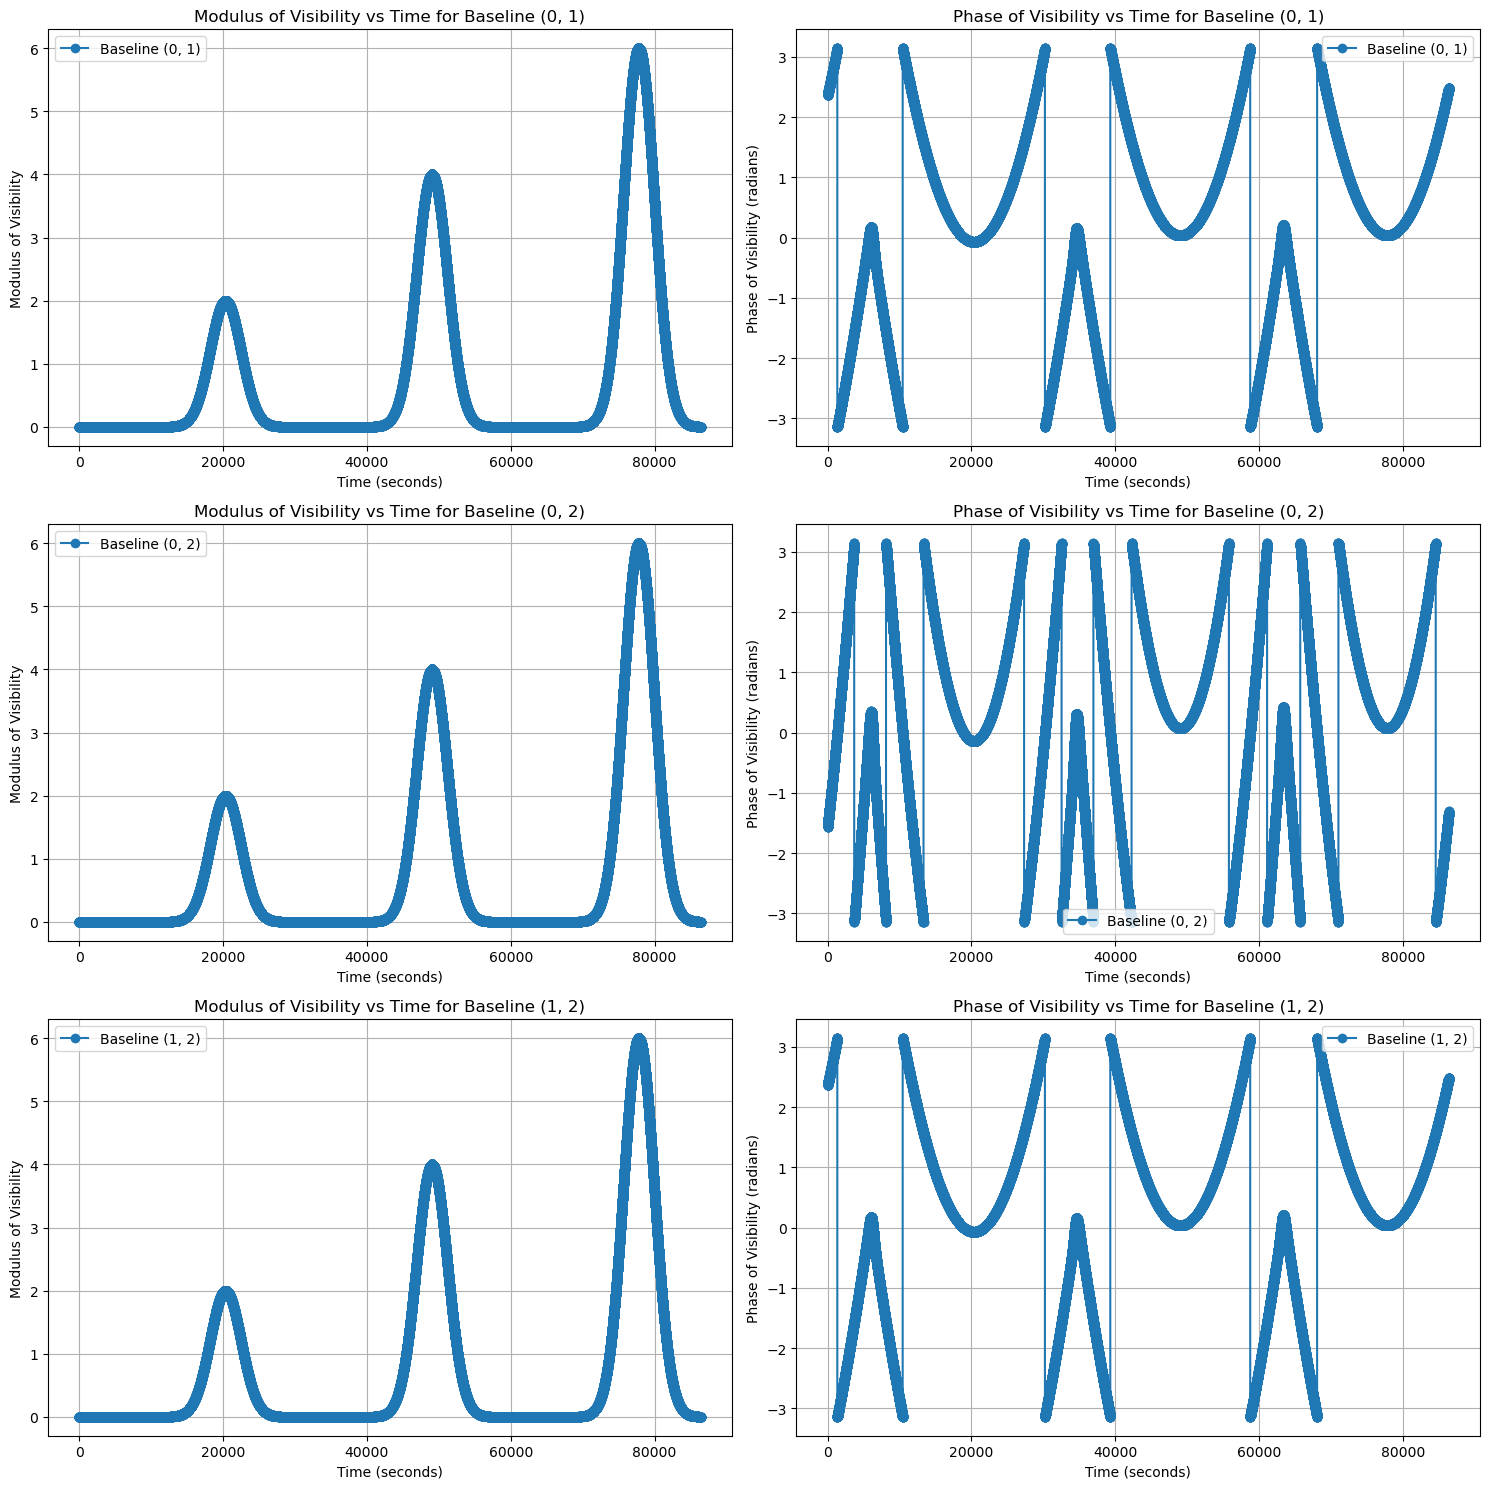

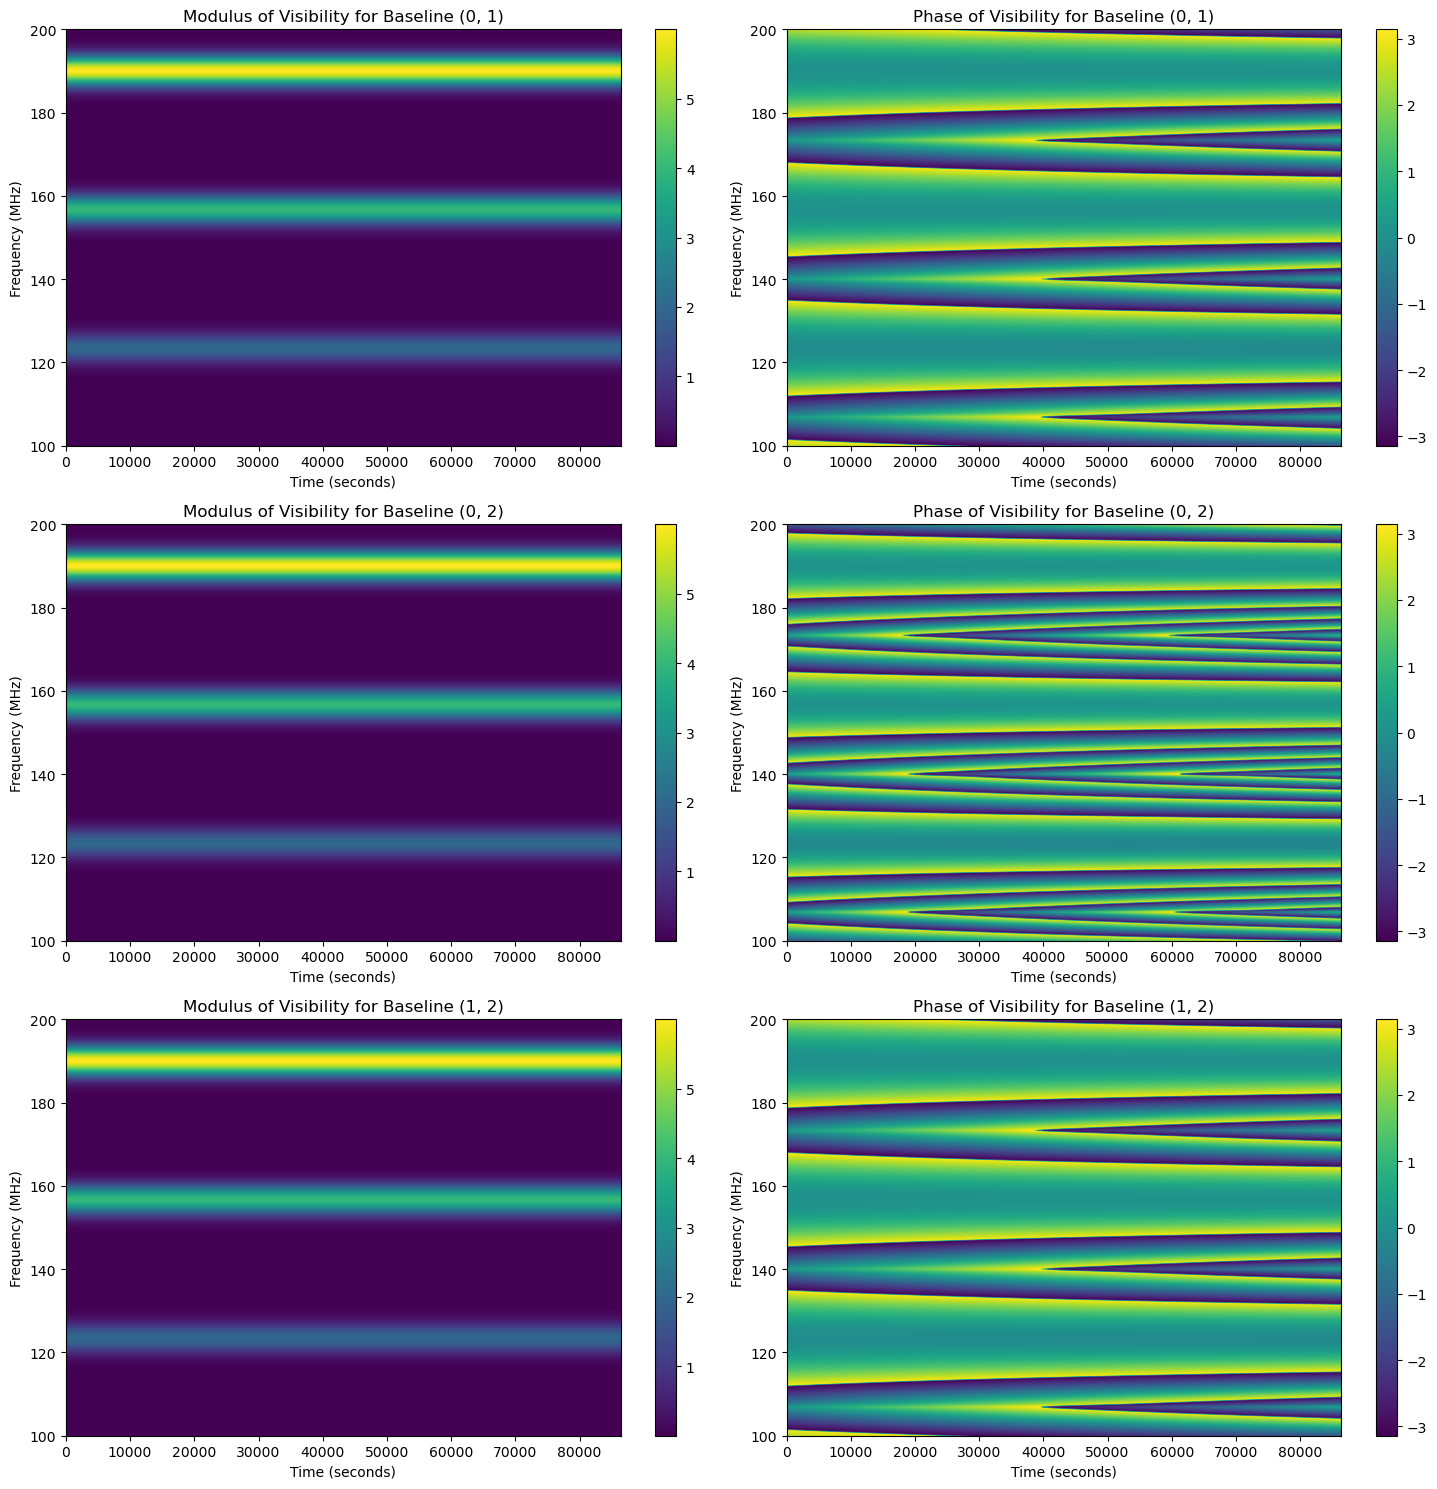

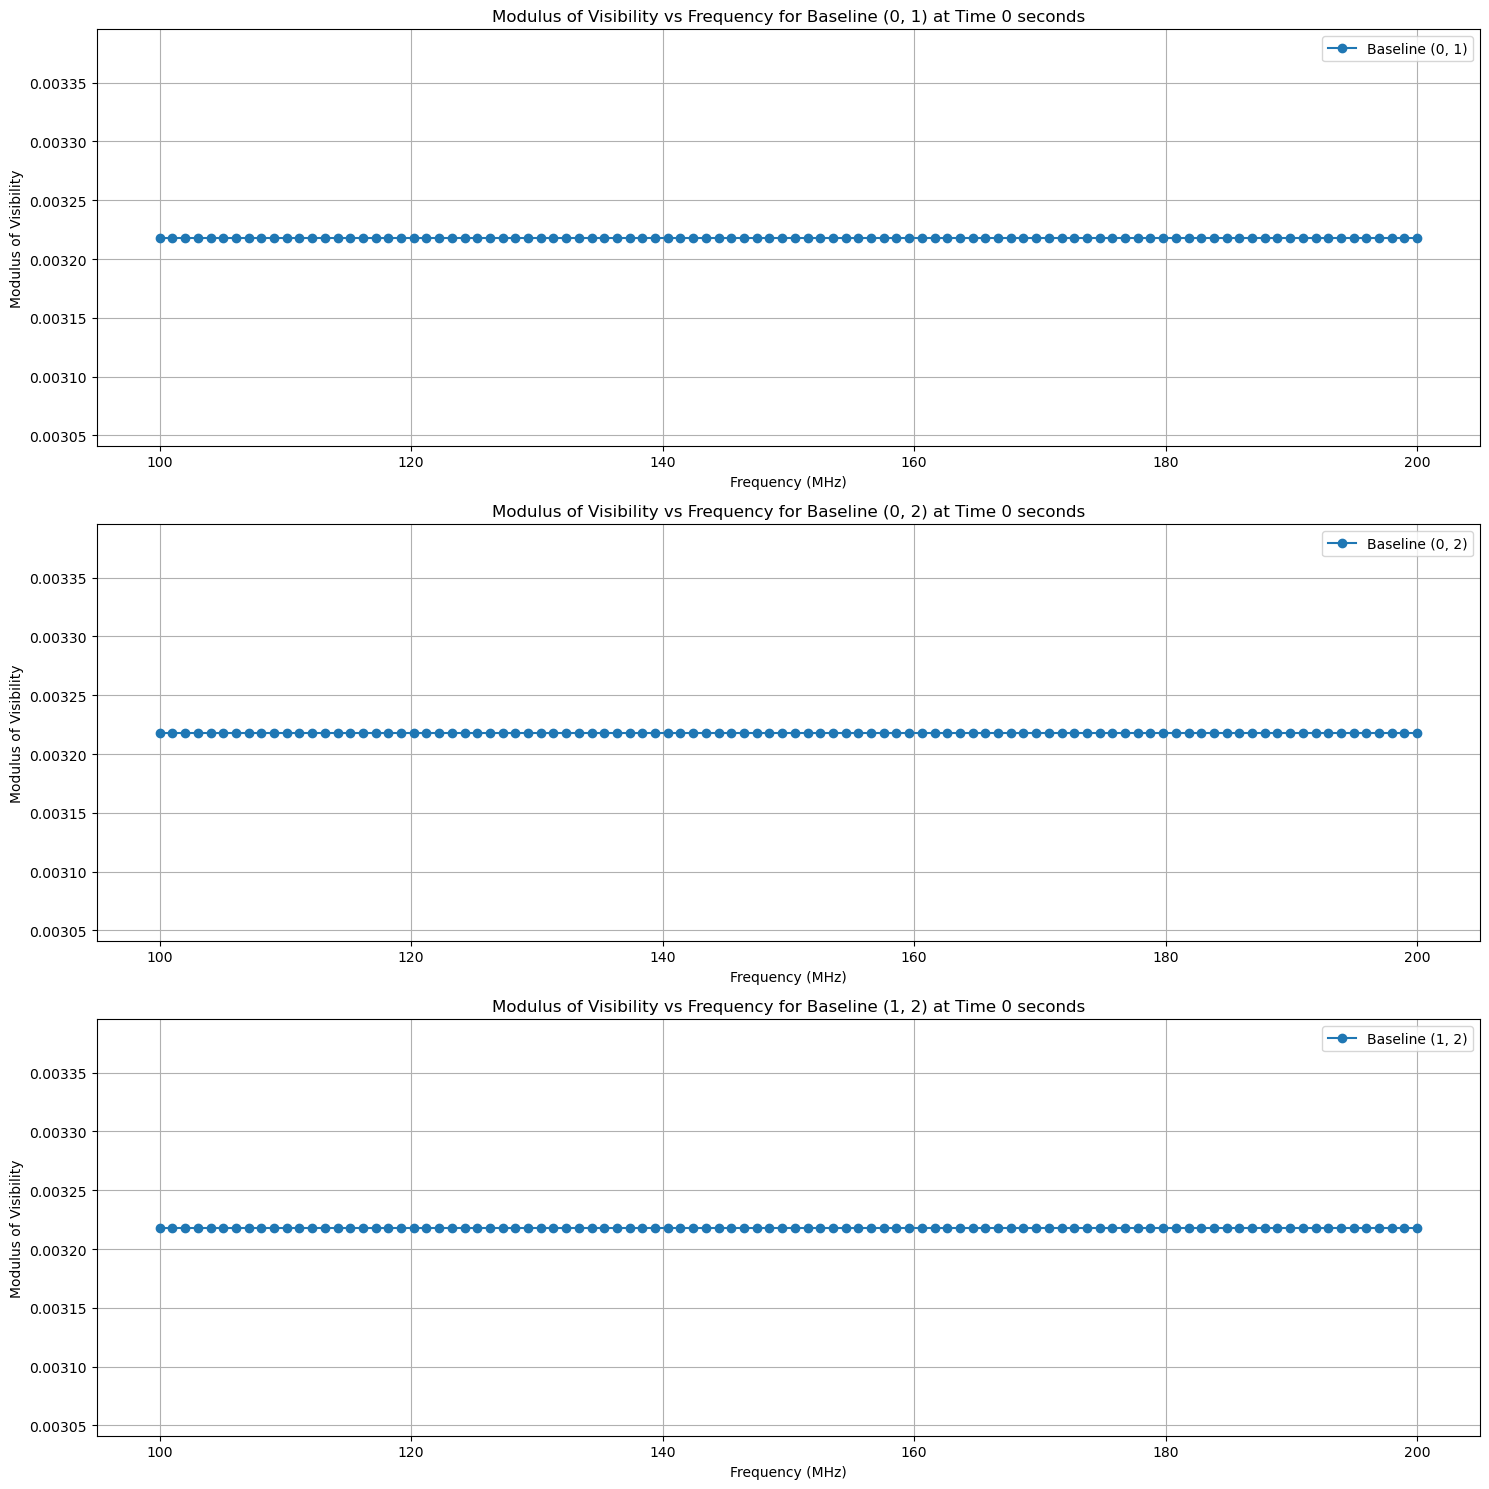

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time, TimeDelta
from astropy.constants import c
import astropy.units as u

# Antenna positions in east-west direction (meters)
antennas = {
    0: (0, 0, 0),
    1: (14, 0, 0),
    2: (28, 0, 0)
}

# Baselines in meters
baselines = {
    (0, 1): np.array([14, 0, 0]),
    (0, 2): np.array([28, 0, 0]),
    (1, 2): np.array([14, 0, 0])
}

# Source coordinates and fluxes at the time of observation (at 50 MHz freq)
sources = [
    {'coords': SkyCoord(ra=0*u.deg, dec=-30.72152777777791*u.deg), 'flux': 2},
    {'coords': SkyCoord(ra=120*u.deg, dec=-30.72152777777791*u.deg), 'flux': 4},
    {'coords': SkyCoord(ra=240*u.deg, dec=-30.72152777777791*u.deg), 'flux': 6}
]

sp_index = 0  # Spectral index for all sources

# Location and observation time
hera_lon = 21.428305555555557
hera_lat = -30.72152777777791
hera_height = 1073.0
location = EarthLocation.from_geodetic(lat=hera_lat, lon=hera_lon, height=hera_height)
obstime_start = Time("2024-06-05T00:00:00", format="isot", scale="utc")

# Observation frequency and wavelength
freqs = np.linspace(1e8, 2e8, 100)  # Frequencies from 100 MHz to 200 MHz
wavelengths = c / freqs

# Half-power beam width (assuming 10 degrees)
theta_HPBW = np.deg2rad(10.9)

# Calculate complex visibility
def calculate_visibility(antennas, baselines, sources, location, obstime, wavelengths, freqs, sp_index):
    visibilities = {key: np.zeros(len(wavelengths), dtype=complex) for key in baselines.keys()}
    
    for i, (wavelength, freq) in enumerate(zip(wavelengths, freqs)):
        for (ant1, ant2), baseline in baselines.items():
            u, v, w = np.array(baseline) / wavelength.value  # Convert baseline to units of wavelength
            
            visibility = 0j
            for source in sources:
                altaz = source['coords'].transform_to(AltAz(obstime=obstime, location=location))
                az, alt = altaz.az.rad, altaz.alt.rad
                
                theta = np.deg2rad(90 - altaz.alt.deg)
                l = np.cos(alt) * np.cos(az)
                m = np.cos(alt) * np.sin(az)
                n = np.sin(alt)
                
                # Projected baseline component in the direction of the source
                b_dot_s = u * l + v * m + w * n
                
                # Gaussian primary beam pattern
                A_theta = (np.exp(- (theta / (np.sqrt(2) * theta_HPBW))**2))**2
                
                # Flux adjusted by spectral index
                flux_adj = source['flux'] * (freq / 50e6)**sp_index
                
                # Add contribution to visibility with beam pattern and flux adjustment
                visibility += flux_adj * A_theta * np.exp(-2j * np.pi * b_dot_s)
            
            visibilities[(ant1, ant2)][i] = visibility
    
    return visibilities

# Calculate modulus and phase angle
def calculate_modulus_phase(visibilities):
    moduli = {key: np.abs(val) for key, val in visibilities.items()}
    phases = {key: np.angle(val) for key, val in visibilities.items()}
    return moduli, phases

# Calculate visibility array for every second over 24 hours
seconds_per_hour = 3600
total_seconds = 24 * seconds_per_hour
time_interval = 1  # Run every second
moduli_over_time = {key: [] for key in baselines.keys()}
phases_over_time = {key: [] for key in baselines.keys()}
for second in range(0, total_seconds, time_interval):
    obstime = obstime_start + TimeDelta(second, format='sec')
    visibility_dict = calculate_visibility(antennas, baselines, sources, location, obstime, wavelengths, freqs, sp_index)
    moduli, phases = calculate_modulus_phase(visibility_dict)
    
    for key in baselines.keys():
        moduli_over_time[key].append(moduli[key])
        phases_over_time[key].append(phases[key])

# Convert lists to numpy arrays for plotting
for key in baselines.keys():
    moduli_over_time[key] = np.array(moduli_over_time[key])
    phases_over_time[key] = np.array(phases_over_time[key])

# Plot modulus vs time for each baseline
time_points = np.arange(0, total_seconds, time_interval)
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

baseline_keys = list(baselines.keys())

for i, key in enumerate(baseline_keys):
    ax[i, 0].plot(time_points, moduli_over_time[key][:, 0], marker='o', label=f"Baseline {key}")
    ax[i, 0].set_xlabel('Time (seconds)')
    ax[i, 0].set_ylabel('Modulus of Visibility')
    ax[i, 0].set_title(f'Modulus of Visibility vs Time for Baseline {key}')
    ax[i, 0].legend()
    ax[i, 0].grid(True)
    
    ax[i, 1].plot(time_points, phases_over_time[key][:, 0], marker='o', label=f"Baseline {key}")
    ax[i, 1].set_xlabel('Time (seconds)')
    ax[i, 1].set_ylabel('Phase of Visibility (radians)')
    ax[i, 1].set_title(f'Phase of Visibility vs Time for Baseline {key}')
    ax[i, 1].legend()
    ax[i, 1].grid(True)

plt.tight_layout()
plt.show()

# Plot heatmaps
fig, ax = plt.subplots(3, 2, figsize=(15, 15))

for i, key in enumerate(baseline_keys):
    im0 = ax[i, 0].imshow(moduli_over_time[key], aspect='auto', origin='lower', extent=[0, total_seconds, freqs[0] / 1e6, freqs[-1] / 1e6])
    ax[i, 0].set_xlabel('Time (seconds)')
    ax[i, 0].set_ylabel('Frequency (MHz)')
    ax[i, 0].set_title(f'Modulus of Visibility for Baseline {key}')
    fig.colorbar(im0, ax=ax[i, 0])
    
    im1 = ax[i, 1].imshow(phases_over_time[key], aspect='auto', origin='lower', extent=[0, total_seconds, freqs[0] / 1e6, freqs[-1] / 1e6])
    ax[i, 1].set_xlabel('Time (seconds)')
    ax[i, 1].set_ylabel('Frequency (MHz)')
    ax[i, 1].set_title(f'Phase of Visibility for Baseline {key}')
    fig.colorbar(im1, ax=ax[i, 1])

plt.tight_layout()
plt.show()

# Plot modulus vs frequency at a particular time (e.g., 0 seconds)
time_index = 0
fig, ax = plt.subplots(3, 1, figsize=(15, 15))

for i, key in enumerate(baseline_keys):
    ax[i].plot(freqs / 1e6, moduli_over_time[key][time_index, :], marker='o', label=f"Baseline {key}")
    ax[i].set_xlabel('Frequency (MHz)')
    ax[i].set_ylabel('Modulus of Visibility')
    ax[i].set_title(f'Modulus of Visibility vs Frequency for Baseline {key} at Time {time_points[time_index]} seconds')
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()
